In [1]:
import os
print(os.getcwd())

c:\Users\aduro\OneDrive\Desktop\Coding\Apziva\Apziva_Project_2\notebooks


### Load Dataset and perform Exploratory Data Analysis:  

In [1]:
# basics
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

def load_deposit():
    # Load csv dataset
    term_deposit_filepath = '../data/raw/term-deposit-marketing-2020.csv'
    #customer_survey_filepath = 'ACME-HappinessSurvey2020.csv'
    term_deposit = pd.read_csv(term_deposit_filepath)
    return term_deposit
term_deposit = load_deposit()

### Exploratory Data Analysis:  


In [7]:
term_deposit.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40000 entries, 0 to 39999
Data columns (total 14 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   age        40000 non-null  int64 
 1   job        40000 non-null  object
 2   marital    40000 non-null  object
 3   education  40000 non-null  object
 4   default    40000 non-null  object
 5   balance    40000 non-null  int64 
 6   housing    40000 non-null  object
 7   loan       40000 non-null  object
 8   contact    40000 non-null  object
 9   day        40000 non-null  int64 
 10  month      40000 non-null  object
 11  duration   40000 non-null  int64 
 12  campaign   40000 non-null  int64 
 13  y          40000 non-null  object
dtypes: int64(5), object(9)
memory usage: 4.3+ MB


In [4]:
term_deposit.describe().T

,count,mean,std,min,25%,50%,75%,max
age,40000.0,40.544600,9.641776,19.0,33.0,39.0,48.0,95.0
balance,40000.0,1274.277550,2903.769716,-8019.0,54.0,407.0,1319.0,102127.0
day,40000.0,16.017225,8.278127,1.0,8.0,17.0,21.0,31.0
duration,40000.0,254.824300,259.366498,0.0,100.0,175.0,313.0,4918.0
campaign,40000.0,2.882175,3.239051,1.0,1.0,2.0,3.0,63.0


In [5]:
# Identify the categorical columns from the dataset.
categorical_cols = term_deposit.select_dtypes(include=['object']).columns
numerical_cols = term_deposit.select_dtypes(include=['int64']).columns

# Obtain unique values for each categorical column and count their occurrences for each column
category_summary = {col: term_deposit[col].value_counts().to_frame(name="count") for col in categorical_cols}
# Combine the summaries into a single dataframe for display
summary_combined = pd.concat(category_summary, axis=0)
summary_combined.index.names = ["feature", "category"]
print(summary_combined)

                         count
feature   category            
job       blue-collar     9383
          management      8166
          technician      6852
          admin           4483
          services        3910
          retired         1437
          self-employed   1414
          entrepreneur    1405
          unemployed      1104
          housemaid       1087
          student          524
          unknown          235
marital   married        24386
          single         10889
          divorced        4725
education secondary      20993
          tertiary       11206
          primary         6270
          unknown         1531
default   no             39191
          yes              809
housing   yes            24031
          no             15969
loan      no             33070
          yes             6930
contact   cellular       24914
          unknown        12765
          telephone       2321
month     may            13532
          jul             6380
        

#### Explore unknown values in dataset  

In [10]:
unknown_counts = (term_deposit == 'unknown').sum()
unknown_counts = unknown_counts[unknown_counts > 0]
unknown_counts

job            235
education     1531
contact      12765
dtype: int64

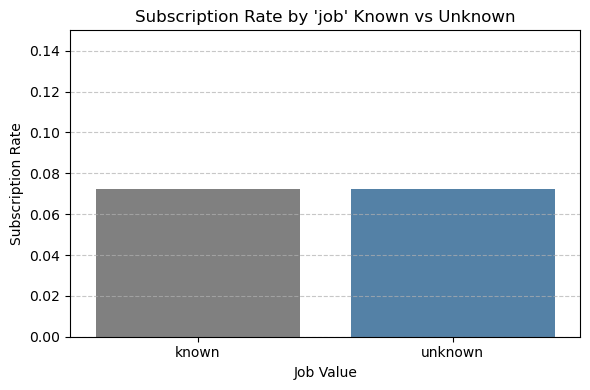

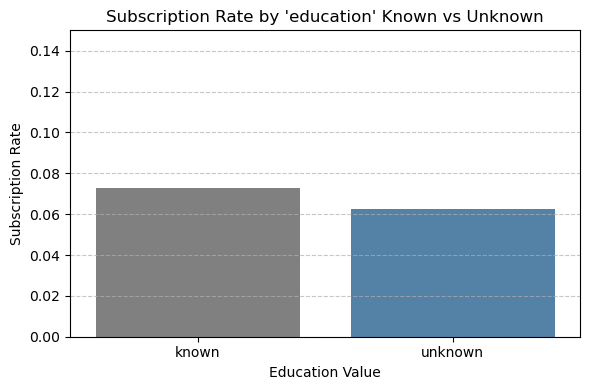

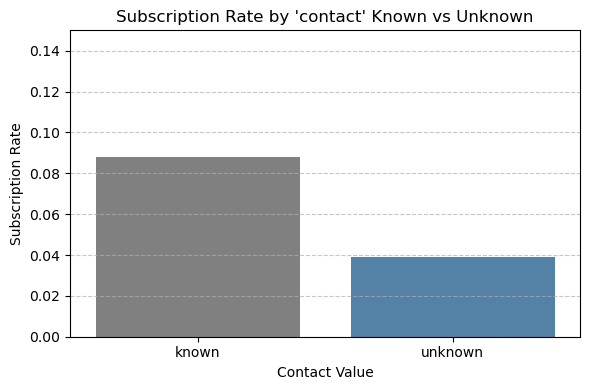

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

def plot_unknowns(term_deposit):
    unknown_deposit = term_deposit.copy()
    # Convert target to binary
    unknown_deposit["y"] = unknown_deposit["y"].map({"yes": 1, "no": 0})

    # features with unknown values
    unknown_features = ['job','education','contact']

    # loop creates new binary columns that indicate whether each row in a feature has unknown value
    for feature in unknown_features:
        unknown_deposit[f"{feature}_unknown"] = unknown_deposit[feature] == 'unknown'
    
    # Plot success rates (proportion of y=1) for 'unknown' vs 'known' in each feature
    for feature in unknown_features:
        col = f"{feature}_unknown"
        rate_term_deposit = unknown_deposit.groupby(col)["y"].mean().reset_index()
        rate_term_deposit[col] = rate_term_deposit[col].map({True: "unknown", False: "known"})

        plt.figure(figsize=(6, 4))
        sns.barplot(data=rate_term_deposit, x=col, y="y", hue=col, palette=["grey", "steelblue"], legend=False)
        plt.title(f"Subscription Rate by '{feature}' Known vs Unknown")
        plt.ylabel("Subscription Rate")
        plt.xlabel(f"{feature.capitalize()} Value")
        plt.ylim(0, 0.15)
        plt.grid(axis='y', linestyle='--', alpha=0.7)
        plt.tight_layout()
        plt.show()

plot_unknowns(term_deposit)

🔍 Column: job (235 unknowns)
Total count is relatively small → you can keep these rows.

Option 1 (Recommended): Treat 'unknown' as a valid category when one-hot encoding.

Option 2: Drop rows if you prefer clean categories and the number is negligible compared to the dataset size.

📘 Column: education (1,531 unknowns)
Higher count but still manageable.

Option 1 (Recommended): Keep 'unknown' as a separate category.

Option 2: Impute with the mode (most frequent value), especially if your model favors cleaner inputs.

☎️ Column: contact (12,765 unknowns)
This is substantial — dropping these rows would remove a significant portion of your data.

Best Option: Keep 'unknown' as a valid level in the one-hot encoding. It may carry useful signal (e.g., failure to reach could correlate with lower success).

Here are the EDA bar plots showing how 'unknown' values in categorical features affect subscription success rates:

Job:

Customers with 'unknown' job values have a slightly lower subscription rate than those with known jobs.

Education:

Those with 'unknown' education levels show a noticeably lower subscription rate than those with known education.

Contact:

'Unknown' contact method leads to the lowest success rate by far — this suggests contact type is a strong signal.



#### Correlation heat map:  

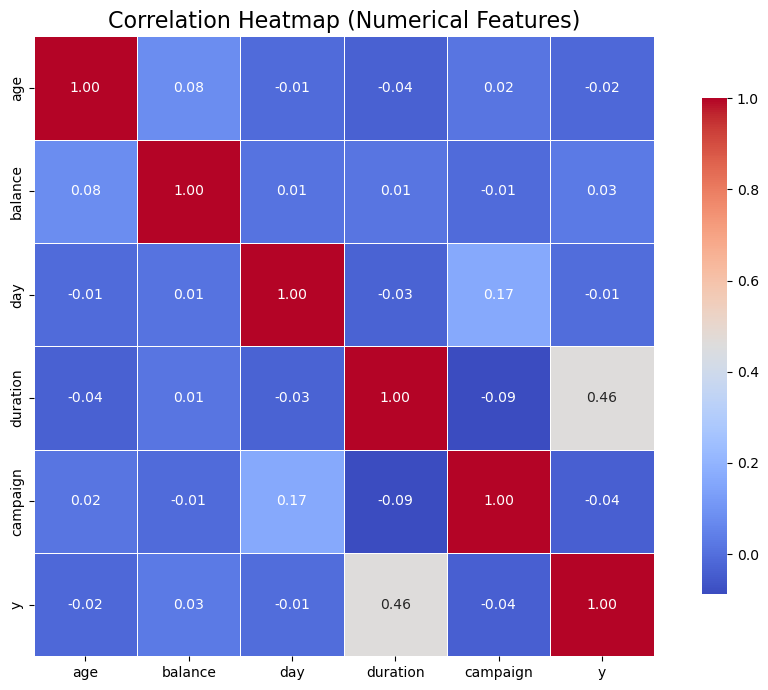

In [10]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# heatmap ofr 
def heatmap(term_deposit):
    correlation_deposit = term_deposit.copy()
    correlation_deposit['y'] = correlation_deposit['y'].map({'yes':1, 'no':0})
    correlation_matrix = correlation_deposit.corr(numeric_only=True)
    fig, ax = plt.subplots(figsize=(10,7))

    sns.heatmap(
        correlation_matrix,
        annot=True,
        cmap='coolwarm',
        fmt='.2f',
        linewidth=0.5,
        square=True,
        cbar_kws={'shrink':0.8},
        ax=ax
        )
    # Set Title
    ax.set_title("Correlation Heatmap (Numerical Features)", fontsize=16)
    # Adjust layout to prevent clipping
    fig.tight_layout()
    # Show plot
    plt.show()
heatmap(term_deposit)

notable correlation between duration and target variable. Very little correlations between each othe features, implies they are independent. No major colinearity among the freatures. 

#### Feature Distributions Numerical

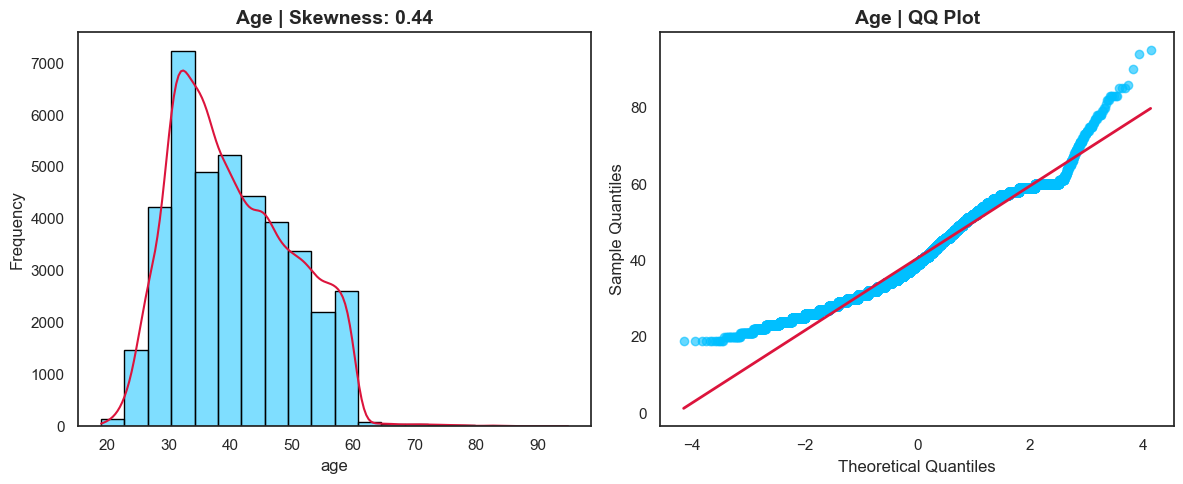

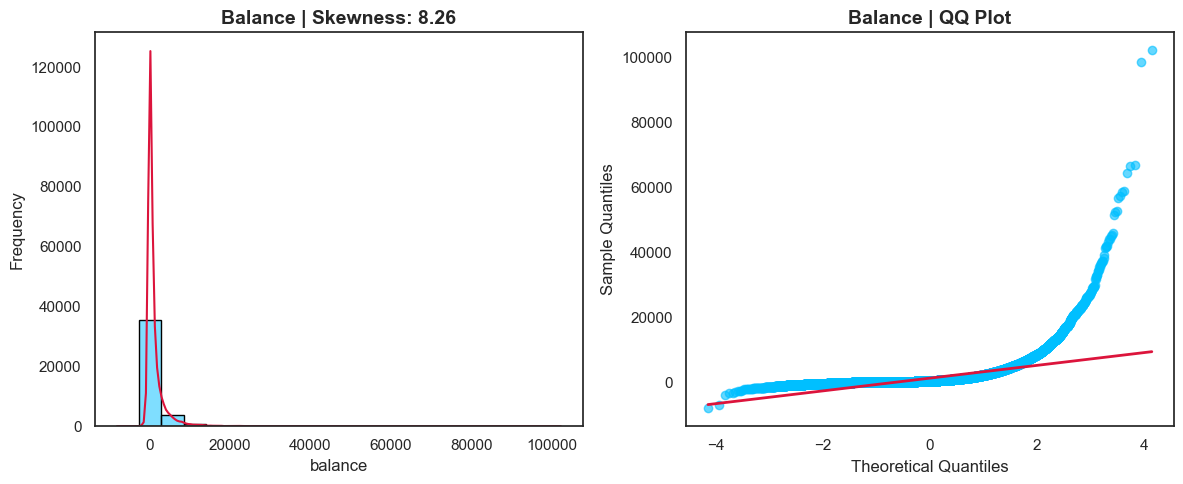

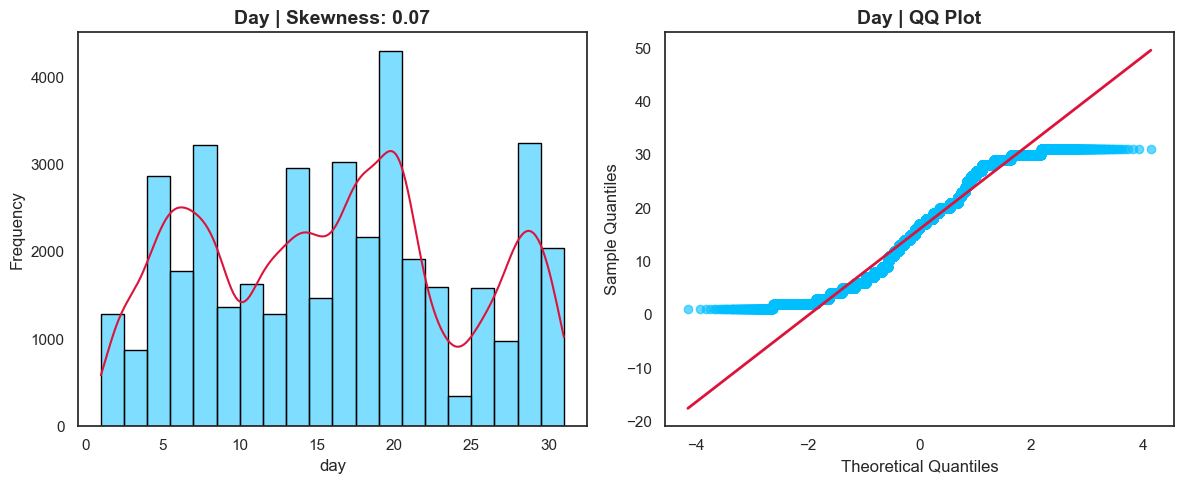

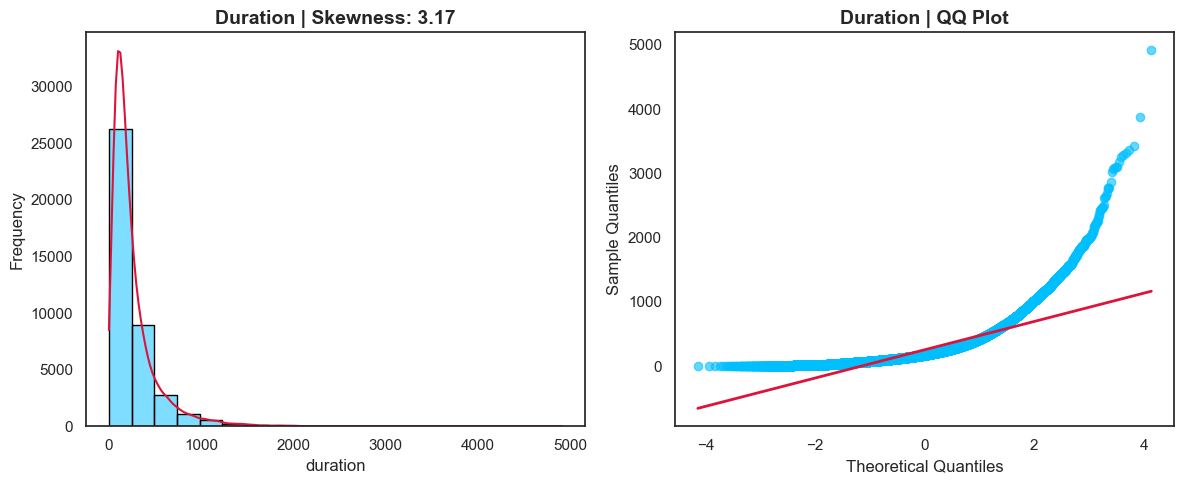

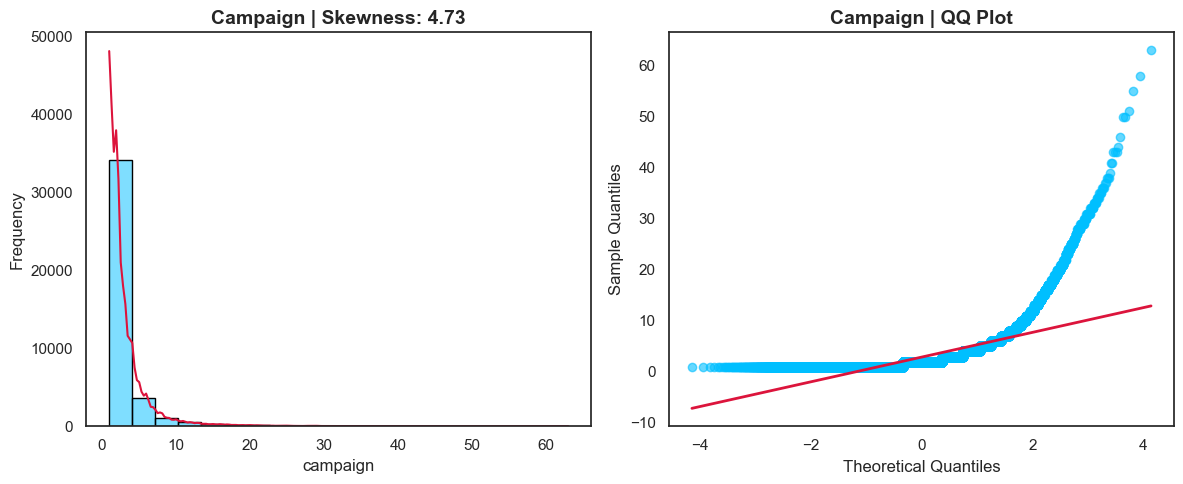

In [35]:
import scipy.stats as stats

# Updated function with bright blue QQ scatterpoints and custom KDE line
def check_skewness_and_qqplots(term_deposit, numerical_cols):
    sns.set_theme(style="white")

    for col in numerical_cols:
        skew_val = term_deposit[col].skew()

        fig, axs = plt.subplots(1, 2, figsize=(12, 5))

        # Histogram with KDE and custom colors
        sns.histplot(term_deposit[col], bins=20, kde=True, ax=axs[0],
                     color='deepskyblue', edgecolor='black', stat='count')

        # Modify KDE line color manually if present
        if axs[0].lines:
            axs[0].lines[0].set_color('crimson')  # change KDE line color

        axs[0].set_title(f'{col.capitalize()} | Skewness: {skew_val:.2f}', fontsize=14, fontweight='bold')
        axs[0].set_xlabel(col, fontsize=12)
        axs[0].set_ylabel("Frequency", fontsize=12)

        # QQ Plot with bright blue scatterpoints and crimson line
        (osm, osr), (slope, intercept, r) = stats.probplot(term_deposit[col], dist="norm")

        axs[1].scatter(osm, osr, color='deepskyblue', alpha=0.6)
        axs[1].plot(osm, slope * osm + intercept, color='crimson', linewidth=2)
        axs[1].set_title(f'{col.capitalize()} | QQ Plot', fontsize=14, fontweight='bold')
        axs[1].set_xlabel("Theoretical Quantiles", fontsize=12)
        axs[1].set_ylabel("Sample Quantiles", fontsize=12)

        plt.tight_layout()
        plt.show()

# Run the customized function
check_skewness_and_qqplots(term_deposit, numerical_cols)

#### Feature Distributions Categorical

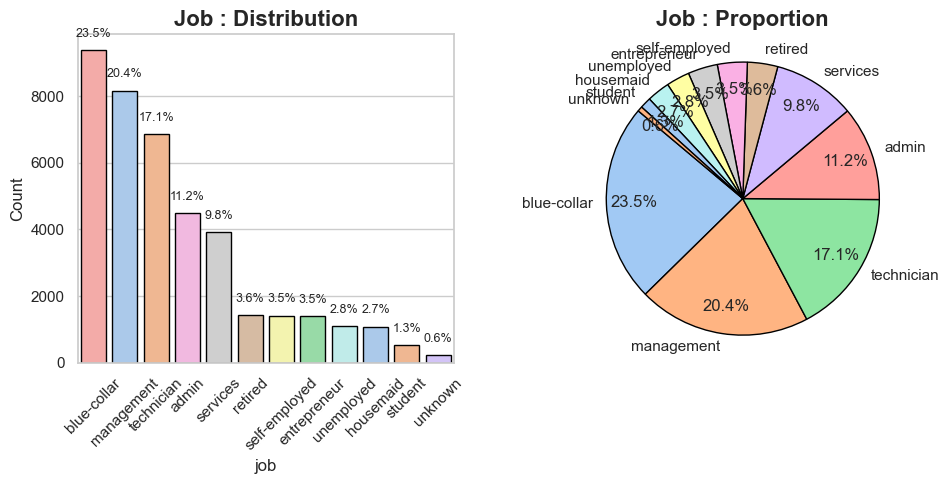

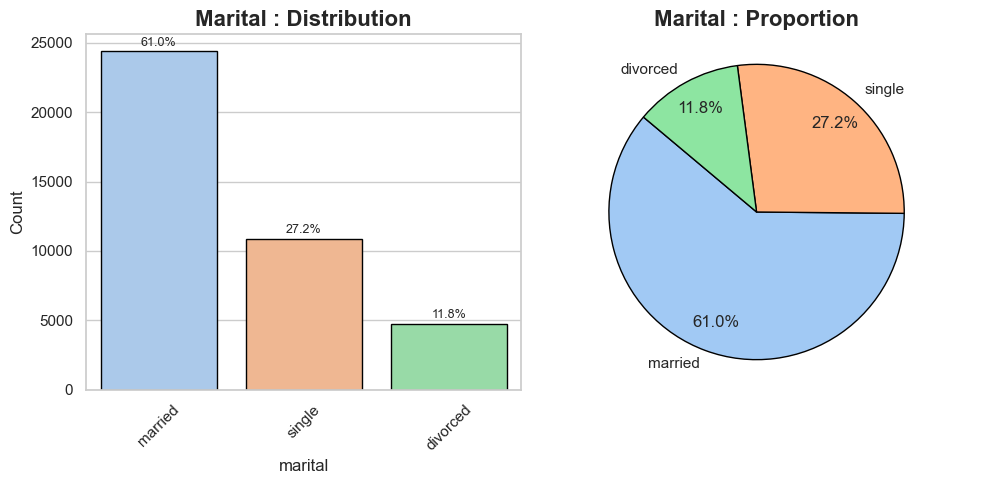

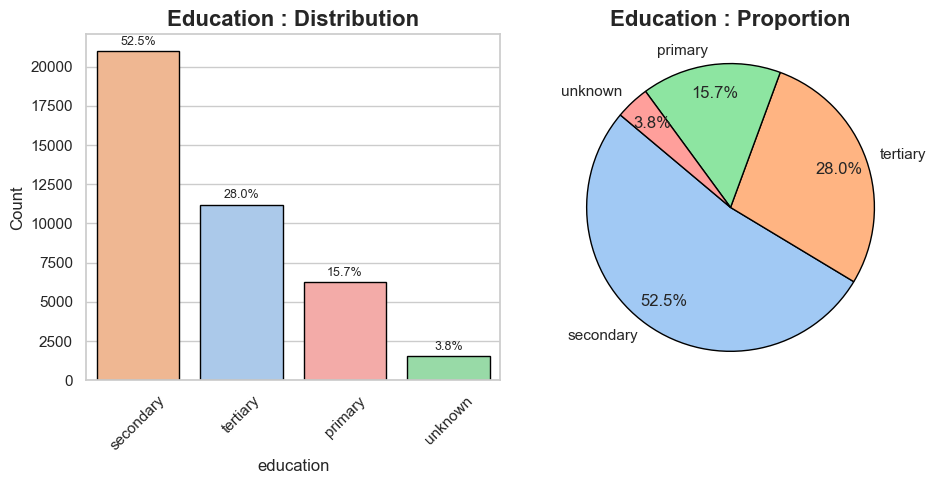

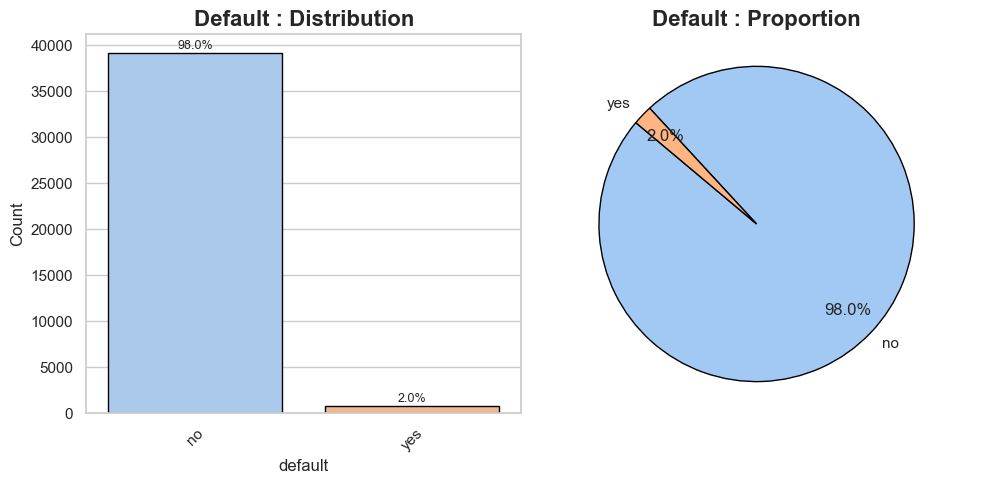

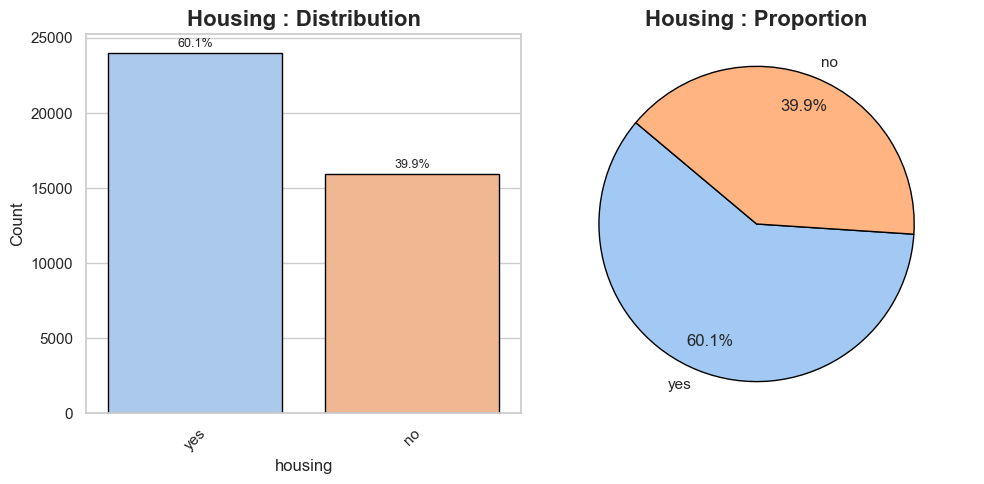

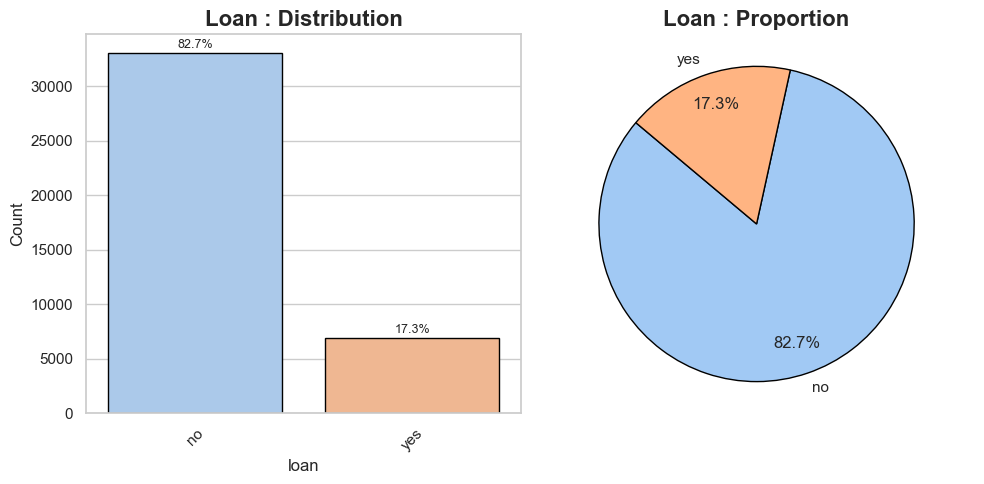

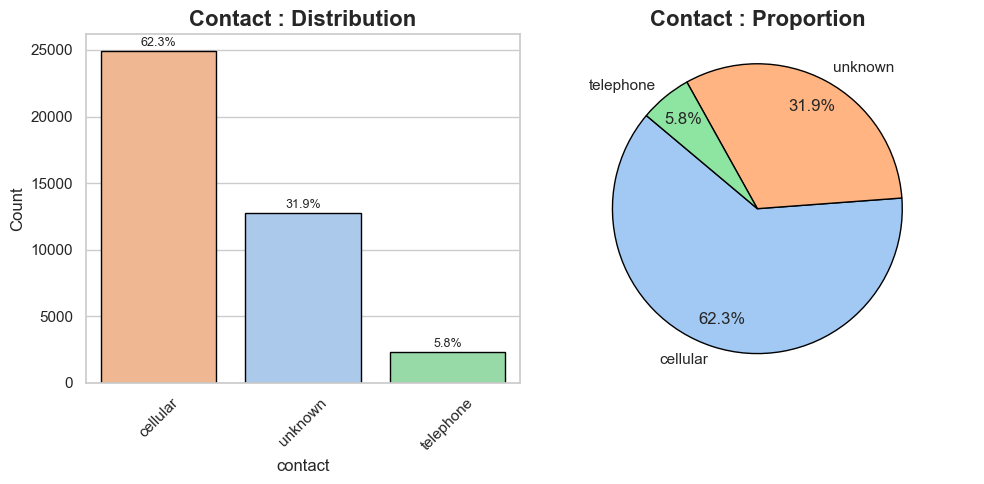

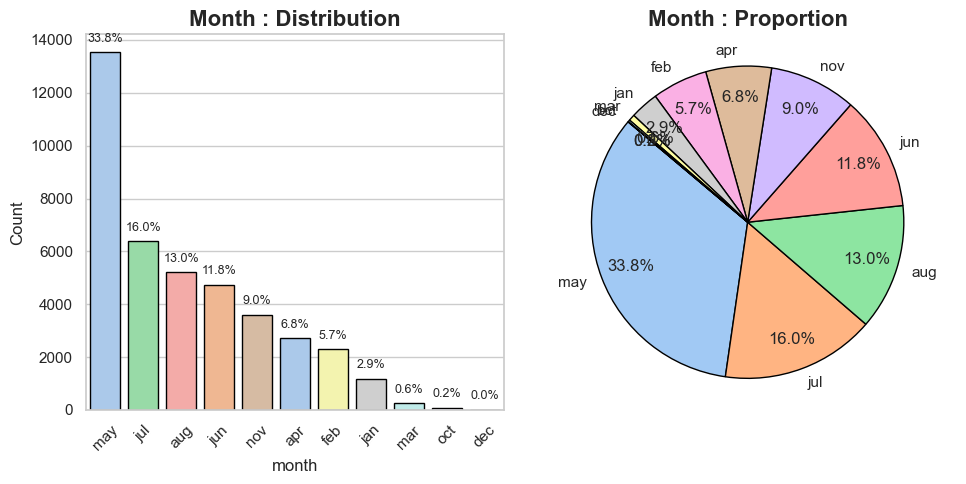

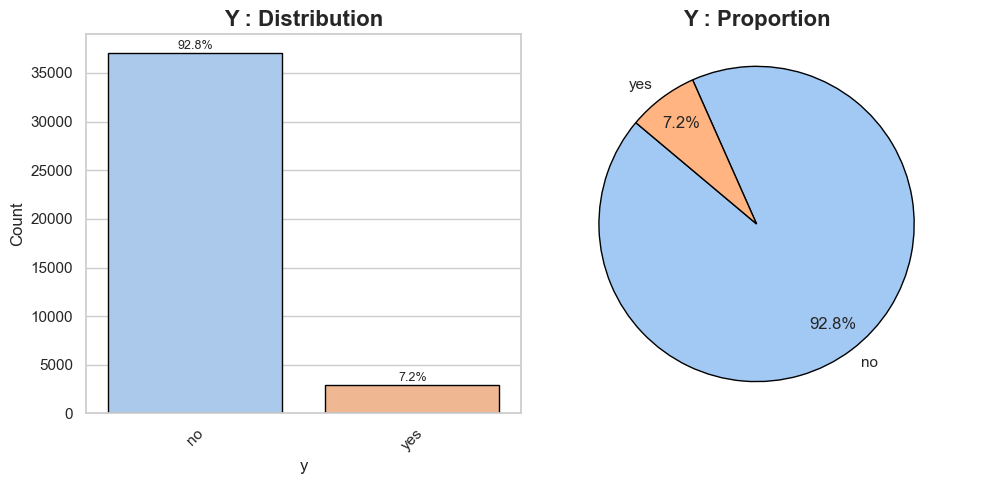

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

# function to plot bar and pie charts for categorical features in the dataset
def plot_categorical_eda(term_deposit,categorical_cols):
    sns.set_theme(style='whitegrid')
    categorical_term_deposit = term_deposit.copy()
    color_palette = sns.color_palette('pastel')

    # Identify the categorical columns from the dataset.
    #categorical_cols = categorical_term_deposit.select_dtypes(include=['object']).columns

    for cat in categorical_cols:
        fig, axs = plt.subplots(1,2, figsize=(10,5))

         # Bar Chart with percentage labels
        value_counts = categorical_term_deposit[cat].value_counts()
        total = len(categorical_term_deposit)
        percentages = (value_counts / total * 100).round(1)
        # Bar Chart
        sns.countplot(x=cat, hue=cat, data=categorical_term_deposit, ax=axs[0], palette=color_palette, edgecolor='black', 
                      order=value_counts.index) 
        # Add percentage labels above bars
        for i, p in enumerate(value_counts):
            axs[0].text(i, p + total * 0.01, f'{(p / total * 100):.1f}%', ha='center', fontsize=9)
        axs[0].set_title(f'{cat.capitalize()} : Distribution', fontsize=16, fontweight='bold')
        axs[0].set_ylabel('Count', fontsize=12)
        axs[0].tick_params(axis='x', rotation=45)

        # Pie Chart
        axs[1].pie(value_counts, labels=value_counts.index,autopct='%1.1f%%', pctdistance=0.8,
                   startangle=140, colors=color_palette, wedgeprops={'edgecolor':'black'})
        axs[1].set_title(f'{cat.capitalize()} : Proportion', fontsize=16, fontweight='bold')
        axs[1].axis('equal')

        plt.tight_layout()
        plt.show()
plot_categorical_eda(term_deposit, categorical_cols)

        





#### Unbalanced dataset

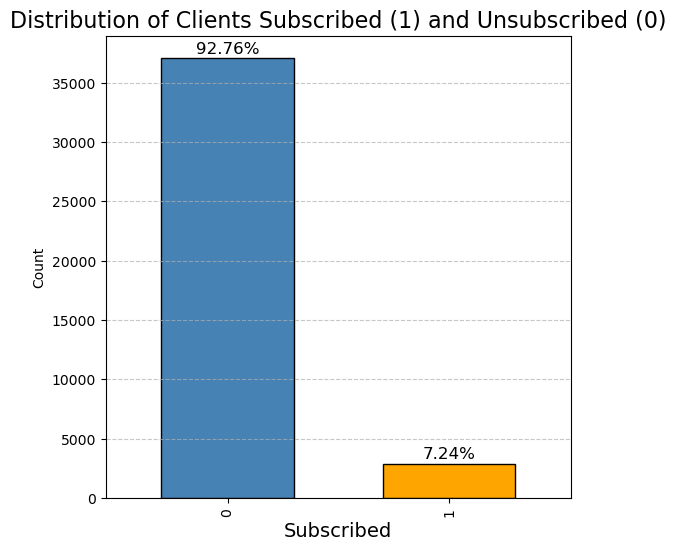

In [21]:
import matplotlib.pyplot as plt

def imbalanced_target(term_deposit):
    # Create figure and axis with optimized size
    fig,ax = plt.subplots(figsize=(6,6))
    imbalanced_deposit = term_deposit.copy()
    imbalanced_deposit['y'] = imbalanced_deposit['y'].map({'yes':1, 'no':0})

    # Calculate counts and percentages
    value_counts = imbalanced_deposit['y'].value_counts()
    total = value_counts.sum()
    percentages = (value_counts / total * 100).round(2)

    # Plot distribution of Target variable
    #bars = imbalanced_deposit['y'].value_counts().plot(
    bars = value_counts.plot(
        kind='bar',
        color=['steelblue','orange'],
        edgecolor='black',
        width=0.6,
        ax=ax
    )
    # Add percentage labels on top of each bar
    for i, value in enumerate(value_counts):
        percent = percentages[i]
        ax.text(i, value + total * 0.01, f"{percent:.2f}%", ha='center', fontsize=12)



    # set labels and title with proper formatting
    ax.set_xlabel('Subscribed', fontsize=14)
    ax.set_ylabel('Count')
    ax.set_title("Distribution of Clients Subscribed (1) and Unsubscribed (0)", fontsize=16)
    ax.yaxis.grid(True,linestyle='--',alpha=0.7)
    plt.show()


imbalanced_target(term_deposit)

#### Outliers:  
Use IQR to detect outliers in numerical features.

In [3]:
# Outlier detection using IQR
# identifies and counts the number of outliers in each numerical column of the dataset using the Interquartile Range Method
def detect_outliers_iqr(term_deposit, numerical_cols):
    # compute the 25th and 75th percentile for each numerical column
    Q1 = term_deposit[numerical_cols].quantile(0.25)
    Q3 = term_deposit[numerical_cols].quantile(0.75)
    # calculates the Interquartile range "middle 50%"
    IQR = Q3 - Q1
    # threshold limits of an outlier
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    # checks for each column which rows fall outside the bounds
    outliers = ((term_deposit[numerical_cols] < lower_bound) | (term_deposit[numerical_cols] > upper_bound)).sum()
    print(outliers[outliers>0])
    

detect_outliers_iqr(term_deposit,numerical_cols)


age           79
balance     4280
duration    3000
campaign    2992
dtype: int64


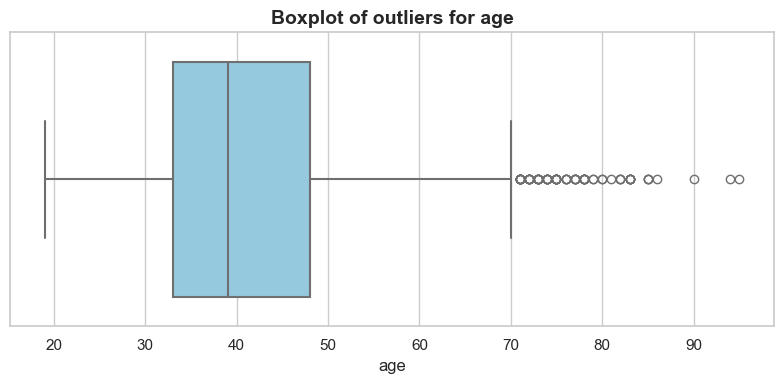

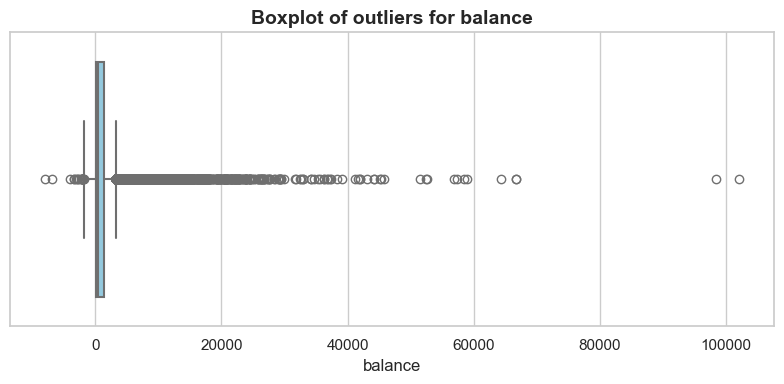

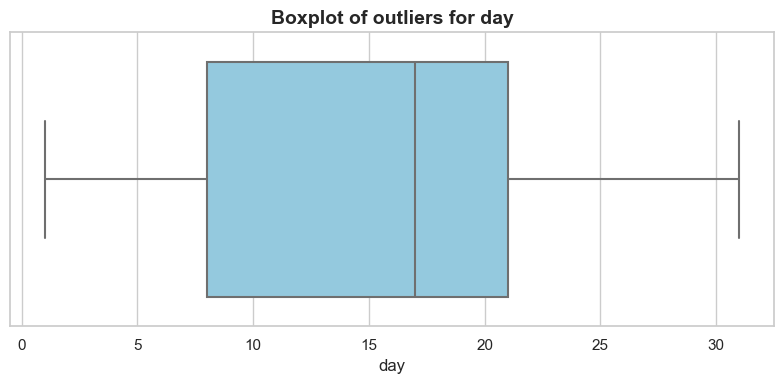

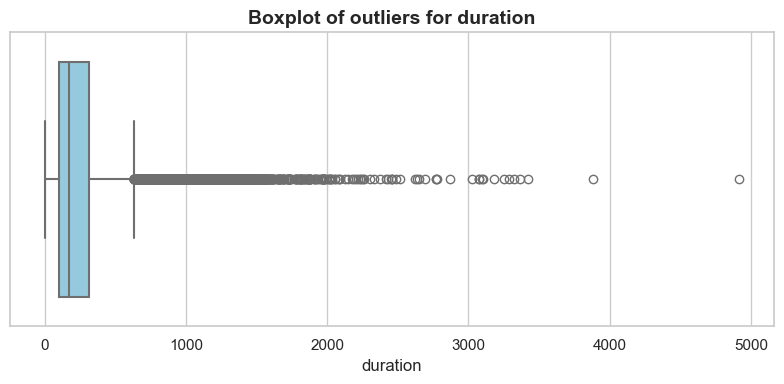

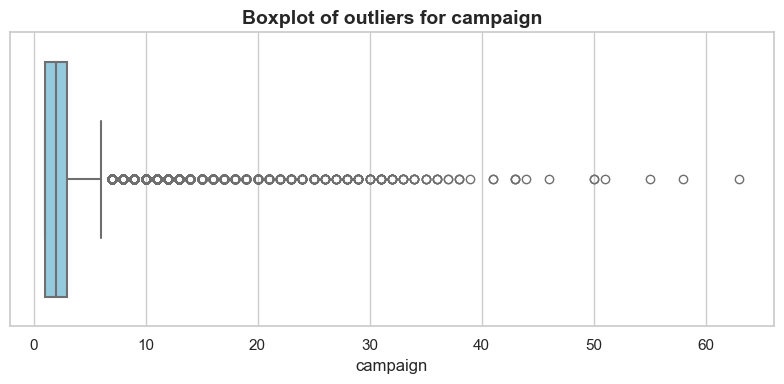

In [5]:
# boxplot visualizing
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

def boxplot_outliers(term_deposit, numerical_cols):
    sns.set_theme(style='whitegrid')
    for num in numerical_cols:
        plt.figure(figsize=(8,4))
        sns.boxplot(x=term_deposit[num], color='skyblue', linewidth=1.5)
        plt.title(f"Boxplot of outliers for {num}", fontsize=14, fontweight='bold')
        plt.xlabel(num, fontsize=12)
        plt.tight_layout()
        plt.show()

boxplot_outliers(term_deposit, numerical_cols)

#### Preprocessing:  
Check for missing values: None

##### One-hot Encoding to handle different data type features (categorical and numerical):  
One-hot encoding is a method to convert categorical features into a numerical format that machine learning models can utlizie. Simply assigning numbers to categories (e.g. job: 'staff' = 2, 'scientist' = 5) can mislead our ML models to think there is an ordinal relationship. The term deposit dataset shown above has 13 features and 40,000 data point of which 9 of the features are categorical. 

In [ ]:
# Identify the categorical columns from the dataset.
categorical_cols = term_deposit.select_dtypes(include=['object']).columns

# Obtain unique values for each categorical column and count their occurrences for each column
category_summary = {col: term_deposit[col].value_counts().to_frame(name="count") for col in categorical_cols}
# Combine the summaries into a single dataframe for display
summary_combined = pd.concat(category_summary, axis=0)
summary_combined.index.names = ["feature", "category"]
print(summary_combined)

                         count
feature   category            
job       blue-collar     9383
          management      8166
          technician      6852
          admin           4483
          services        3910
          retired         1437
          self-employed   1414
          entrepreneur    1405
          unemployed      1104
          housemaid       1087
          student          524
          unknown          235
marital   married        24386
          single         10889
          divorced        4725
education secondary      20993
          tertiary       11206
          primary         6270
          unknown         1531
default   no             39191
          yes              809
housing   yes            24031
          no             15969
loan      no             33070
          yes             6930
contact   cellular       24914
          unknown        12765
          telephone       2321
month     may            13532
          jul             6380
        

In [ ]:
# Separate features and target
X = term_deposit.drop(columns=["y"])
y = term_deposit["y"].apply(lambda val: 1 if val == "yes" else 0)